## Auswertung der Lebensdauertest CSV Dateien

### Import Block

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


### Import CSV-Dateien

In [ ]:
p = Path("lebensdauertest")
csv_list = list(p.glob('**/*.csv'))

In [ ]:
# Assuming csv_list is already defined
data_frames = []  # To store the filtered and renamed DataFrames

for path in csv_list:
    df = pd.read_csv(path, parse_dates=["times"])
    # Identify the specific columns for "northSensorAngle" and "torque" that contain "t2"
    angle_column = [col for col in df.columns if "northSensorAngle" in col and "t2" in col][0]
    torque_column = [col for col in df.columns if "torque" in col and "t2" in col][0]
    set_angle_column = [col for col in df.columns if any(keyword in col for keyword in ["SetAngle", "setAngle"]) and "t2" in col][0]

    # Keep only the columns of interest (already renamed in the DataFrame)
    columns_of_interest = ["times", angle_column, torque_column,set_angle_column]
    
    # Filter the DataFrame to only include these columns
    filtered_df = df[columns_of_interest]

    # Rename the columns in the filtered DataFrame
    filtered_df_renamed = filtered_df.rename(columns={
        angle_column: "northsensoranglet2",
        torque_column: "torquet2",
        set_angle_column : "setanglet2"

    })

    # Store the filtered and renamed DataFrame
    data_frames.append(filtered_df_renamed)

# Now, data_frames contains all your DataFrames with consistent and renamed column names
data_frames


### Show  Timedeltas and intervals where Data is available

In [ ]:
days = datetime.timedelta(microseconds=0)
for df in data_frames:
    td = df["times"] [len(df["times"])-1] - df["times"][0]
    print(f'Start date at: {df["times"][0]}; End date at: {df["times"] [len(df["times"])-1]}')
    days += td
print(f'Total days with Data: {days}')

In [ ]:
# Initialize start and end dates for the entire dataset
start_date = pd.to_datetime('2099-12-31')  # Set a default future start date
end_date = pd.to_datetime('1900-01-01')    # Set a default past end date

# Loop to find the overall start and end dates
for df in data_frames:
    current_start = df["times"].min()
    current_end = df["times"].max()
    if current_start < start_date:
        start_date = current_start
    if current_end > end_date:
        end_date = current_end

# Generate a date range for the entire period
date_range = pd.date_range(start_date, end_date)

# Initialize a DataFrame to track data availability
data_availability = pd.DataFrame(index=date_range, columns=['Data Available'])
data_availability['Data Available'] = 0  # Assume no data initially

# Loop through each CSV file to mark days with data
for df in data_frames:
    for date in df['times'].dt.date.unique():
        data_availability.loc[pd.to_datetime(date), 'Data Available'] = 1



In [ ]:
data_with_data_only = data_availability[data_availability['Data Available'] == 1]

plt.figure(figsize=(30, 5))  # Adjust the size as needed
plt.scatter(data_with_data_only.index, data_with_data_only, marker='o')

# Format the x-axis to show dates with a specific interval and format
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Show a tick for every week
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the date

plt.title('Data Availability Over Time')
plt.xlabel('Date')
plt.ylabel('Data Available')
plt.yticks([0, 1], ['No', 'Yes'])  # Only show two ticks on the y-axis for presence/absence of data
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate xticks for better readability if they're still too crowded
plt.show()


In [ ]:
def find_zero_torque_intervals(df, torque_column):
    """
    Identifies hourly intervals where the mean torque is zero.
    
    :param df: DataFrame indexed by datetime and containing torque data.
    :param torque_column: The name of the column containing torque values.
    :return: List of start timestamps for intervals with zero mean torque.
    """
    # Make sure the DataFrame is indexed by datetime for resampling
    if not isinstance(df.index, pd.DatetimeIndex):
        # Attempt to set 'times' as the index assuming it's a column in df
        df = df.set_index('times')

    # Resample to hourly and calculate mean torque for each interval
    hourly_means = df.resample('H').mean()
    
    # Filter intervals where the mean torque is 0
    zero_torque_intervals = hourly_means[hourly_means[torque_column] == 0]
    
    return zero_torque_intervals.index.tolist()

In [ ]:
sum_intervals = 0
zero_torque_intervals_summary = {}

for df in data_frames:
    # Temporary fix to ensure 'times' column exists before resetting index
    if 'times' not in df.columns:
        df['times'] = df.index

    # Ensure 'times' is datetime type and set as index
    df['times'] = pd.to_datetime(df['times'])
    df.set_index('times', inplace=True)
    
    # Identify zero torque intervals
    zero_intervals = find_zero_torque_intervals(df, "torquet2")
    first_timestamp = df.index[0].strftime('%Y-%m-%d %H:%M:%S')
    zero_torque_intervals_summary[first_timestamp] = len(zero_intervals)
    sum_intervals += len(zero_intervals)
    
    # Reset index after operations requiring DatetimeIndex are complete
    df.reset_index(inplace=True)
    
    # Plotting
    plt.figure(figsize=(30, 5))
    df.plot(x="times", y=["torquet2", "northsensoranglet2"], title=f"Data starting from {first_timestamp}")
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

print(f"Total zero torque intervals across all data: {sum_intervals}")
for start_time, count in zero_torque_intervals_summary.items():
    print(f"{start_time}: {count} zero torque intervals")


In [ ]:
# Concatenate all DataFrames into a single DataFrame again to ensure a fresh start
combined_df = pd.concat(data_frames)

# Make sure 'times' is in datetime format and set as the index
combined_df['times'] = pd.to_datetime(combined_df['times'])
combined_df.set_index('times', inplace=True)

# Proceed with previous steps

# Ensure all data is float type for calculations
combined_df['torquet2'] = pd.to_numeric(combined_df['torquet2'], errors='coerce')

# Optional: Filter out extreme outliers
threshold = combined_df['torquet2'].quantile(0.999)
combined_df = combined_df[combined_df['torquet2'] < threshold]
# Assuming 'combined_df' is already prepared and set as described
combined_df['torquet2'] = np.abs(combined_df['torquet2'])*110
# Recalculate hourly means with the index correctly set
hourly_means = combined_df.resample('15T').mean()

# Optionally adjust the 'torquet2' values if needed before plotting

plt.figure(figsize=(30, 5))

# Format the x-axis to show dates with a specific interval and format
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Adjust interval as necessary for your data
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.plot(hourly_means['torquet2'])
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate xticks for better readability

# Plotting the hourly mean torque over time
plt.ylabel('Mean Torque')
plt.xlabel('Time')

plt.show()


,times,northsensoranglet2,torquet2,setanglet2,SignChange,DirectionChange,tchange,AngleChange,NonZeroChange
2926426,2024-02-13 06:23:25,3.32,0.0,3.0,-1.0,False,0.0,0.0,False
2926427,2024-02-13 06:23:26,3.28,0.0,3.0,-1.0,False,0.0,0.0,False
2926428,2024-02-13 06:23:27,3.28,0.0,3.0,-1.0,False,0.0,0.0,False
2926429,2024-02-13 06:23:28,3.32,0.0,3.0,-1.0,False,0.0,0.0,False
2926430,2024-02-13 06:23:29,3.28,0.0,3.0,-1.0,False,0.0,0.0,False


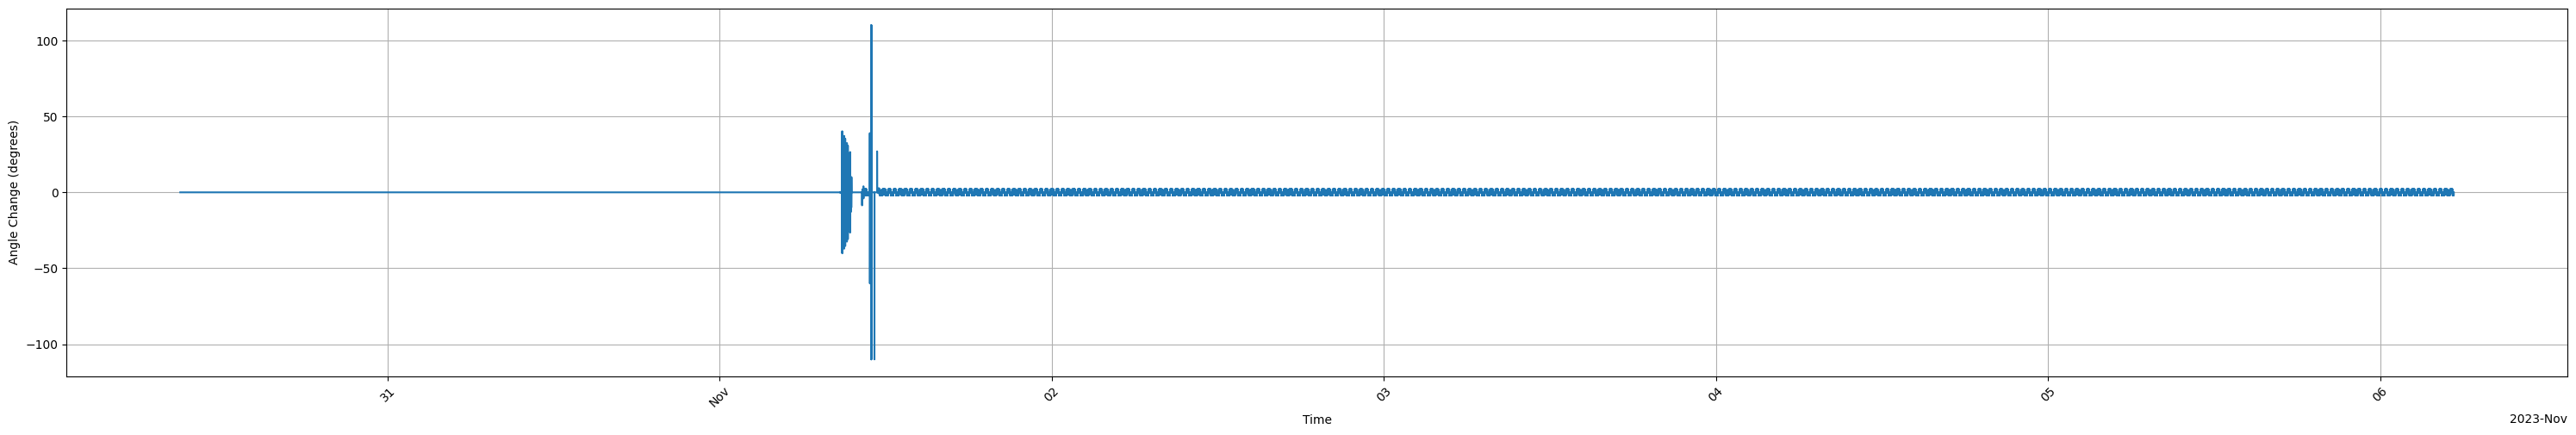

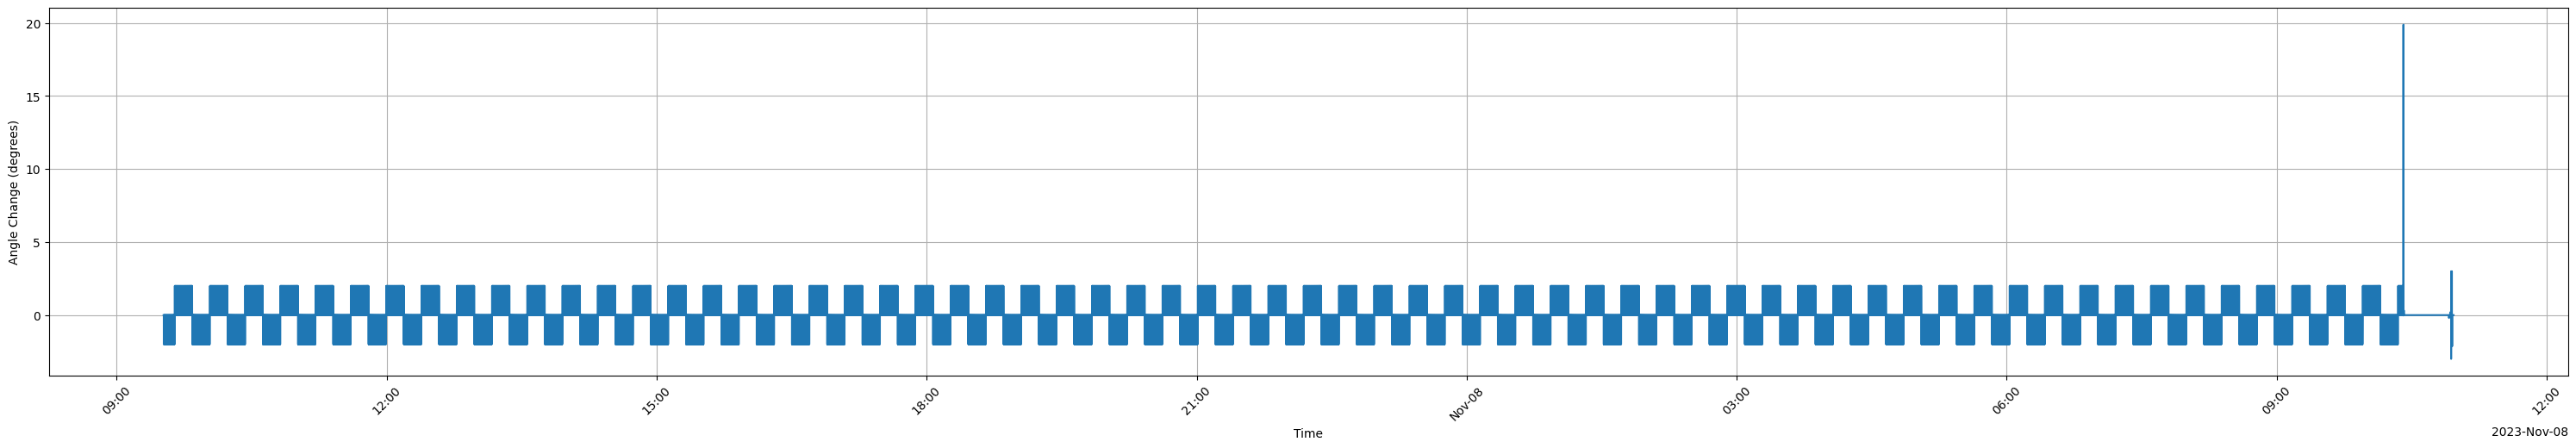

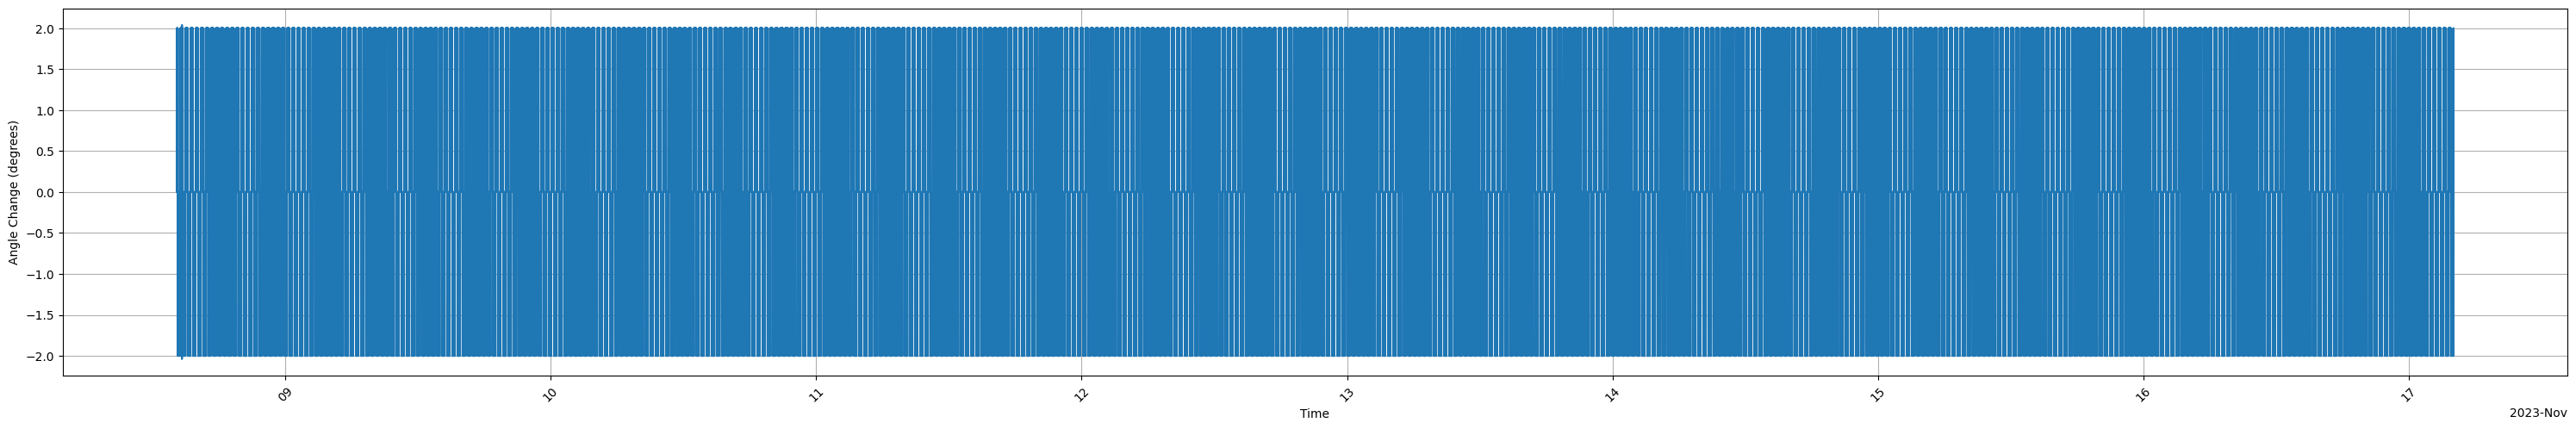

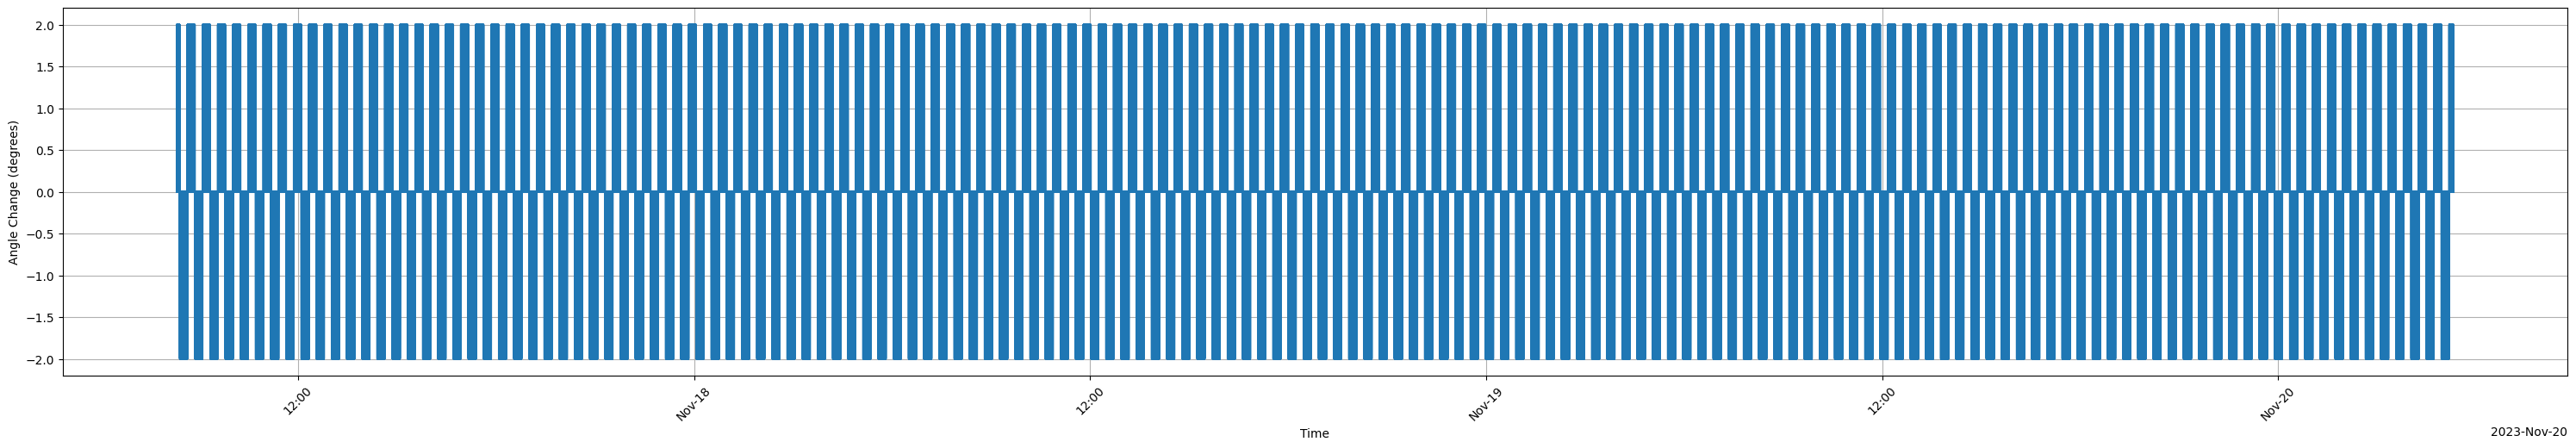

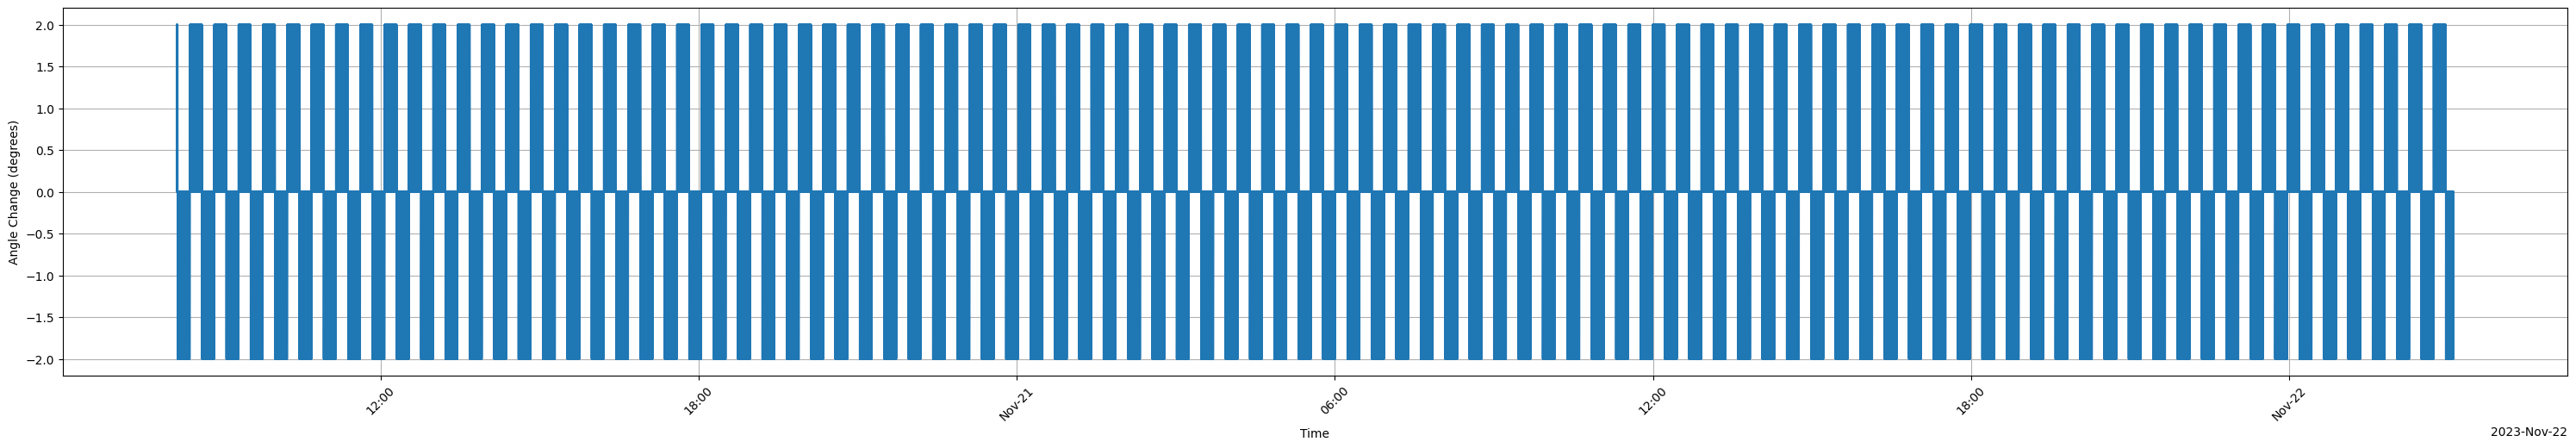

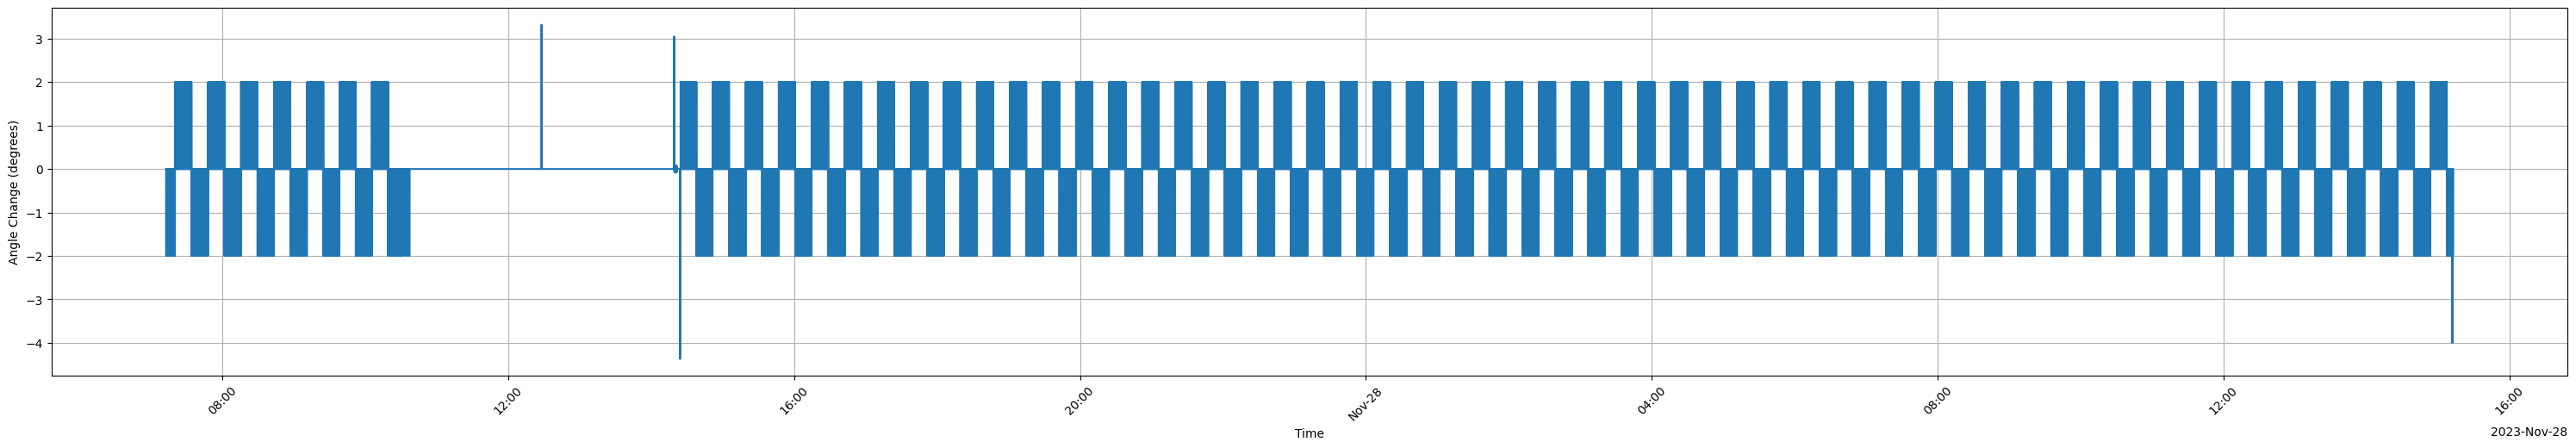

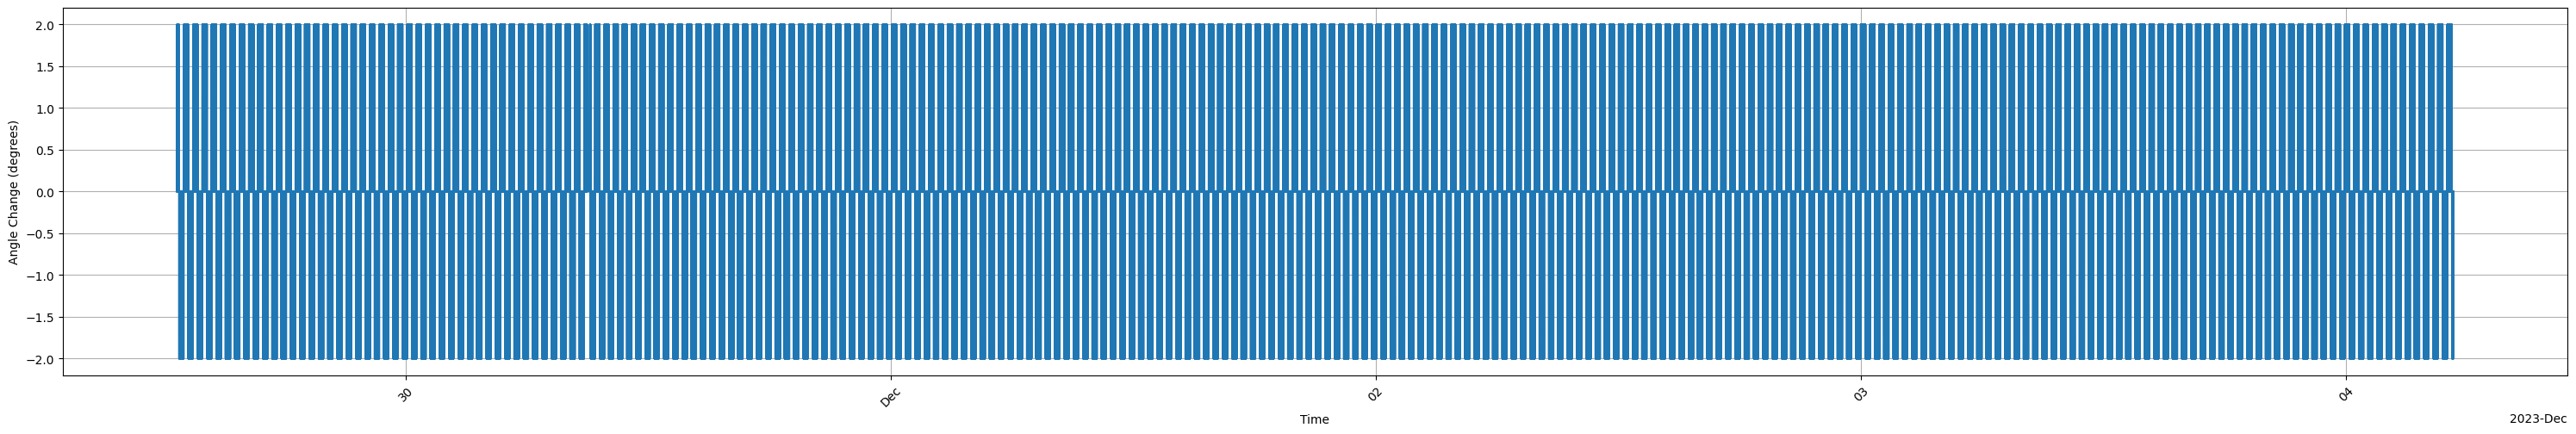

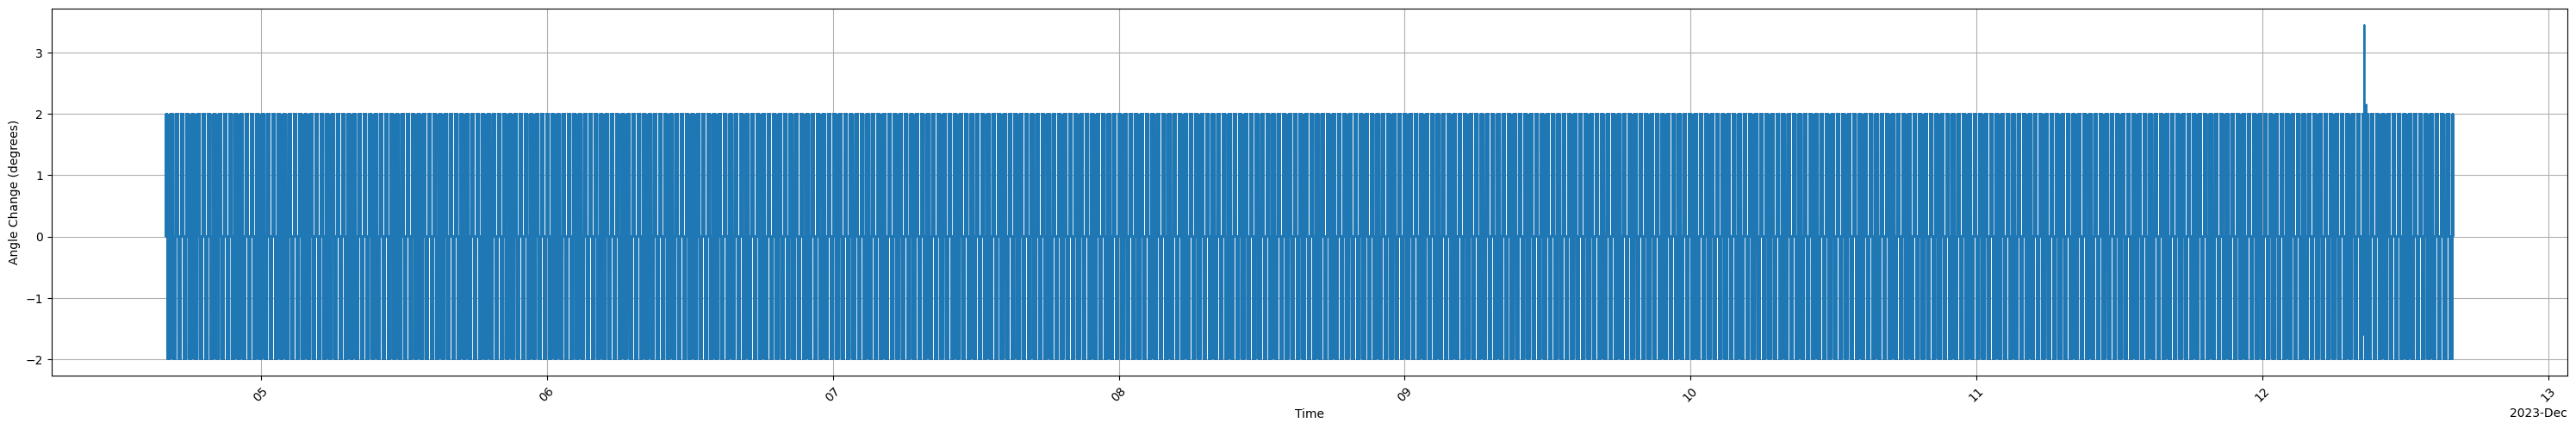

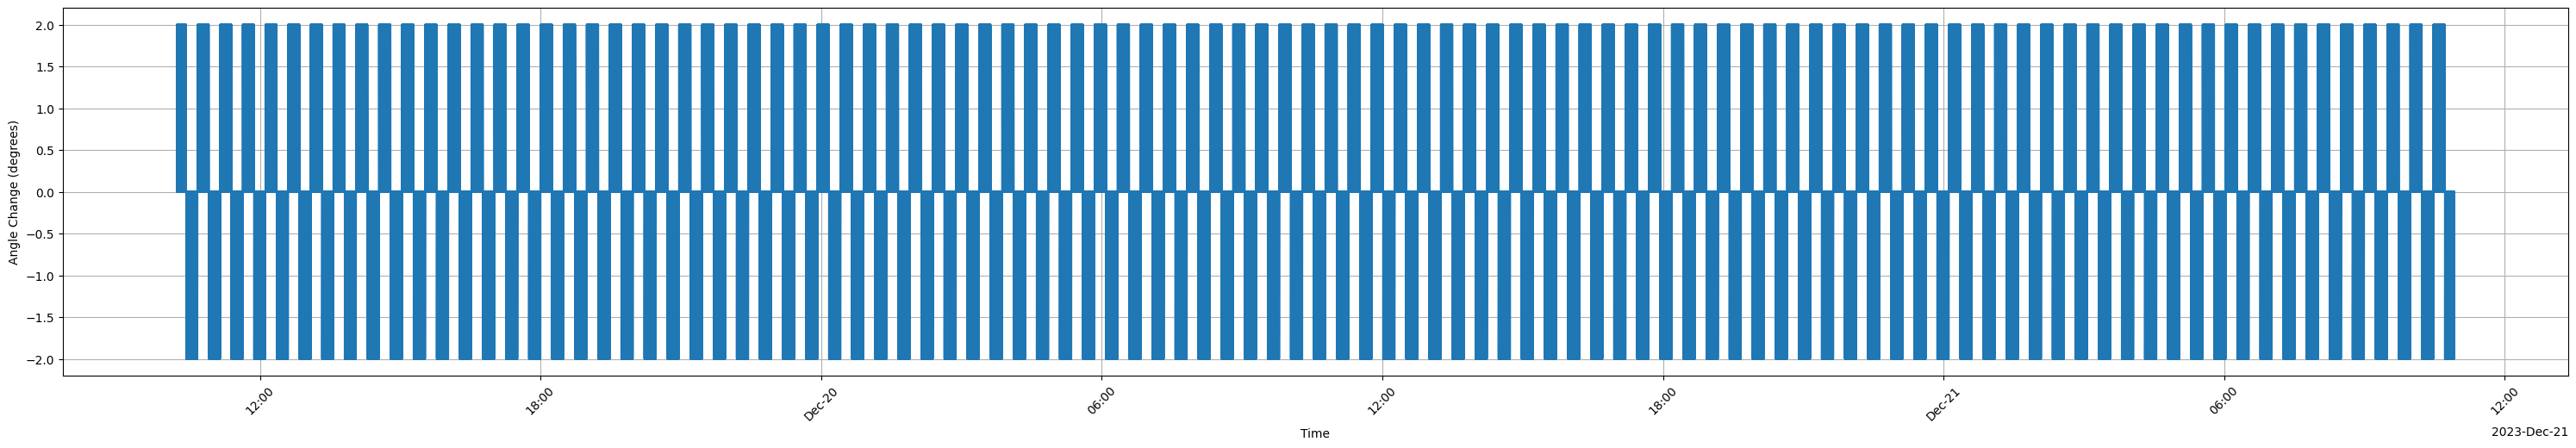

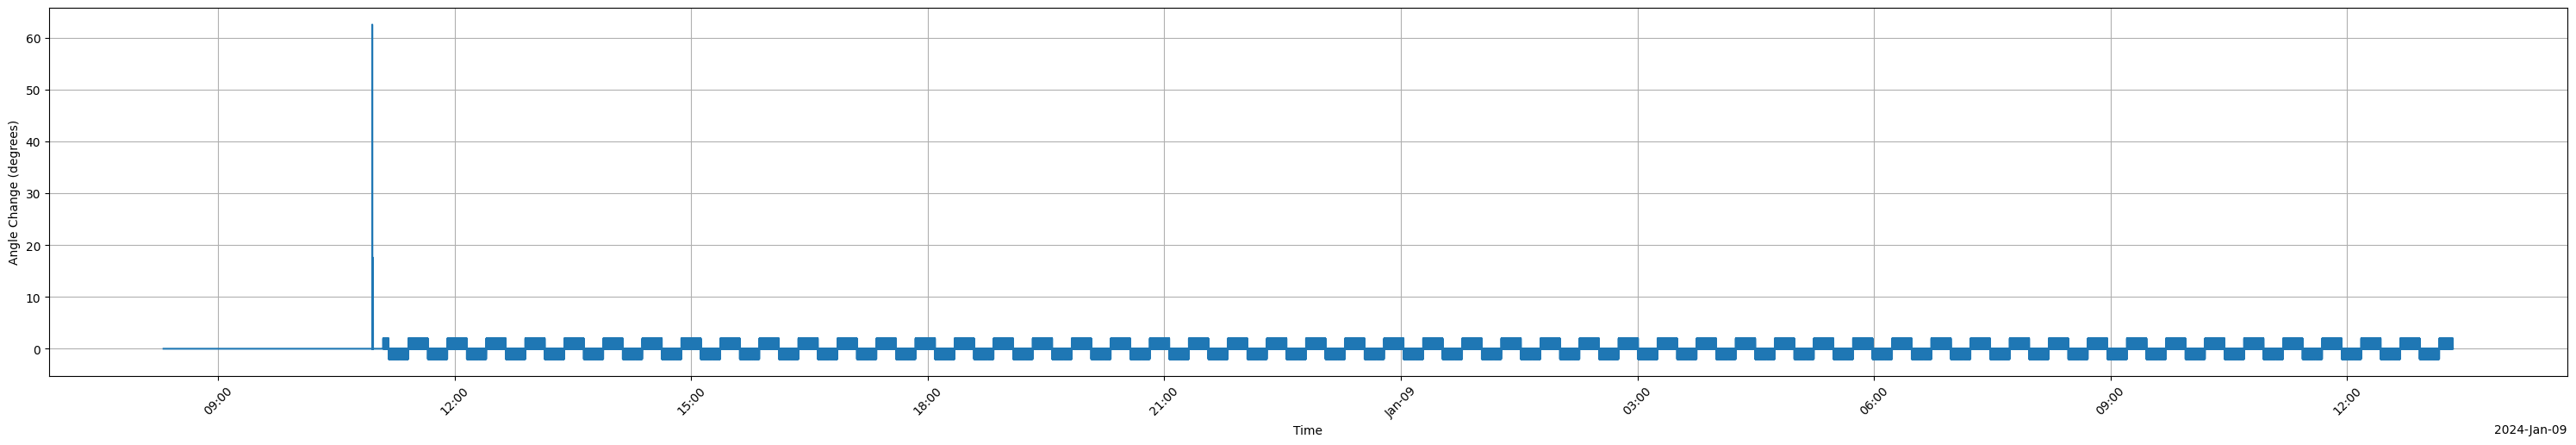

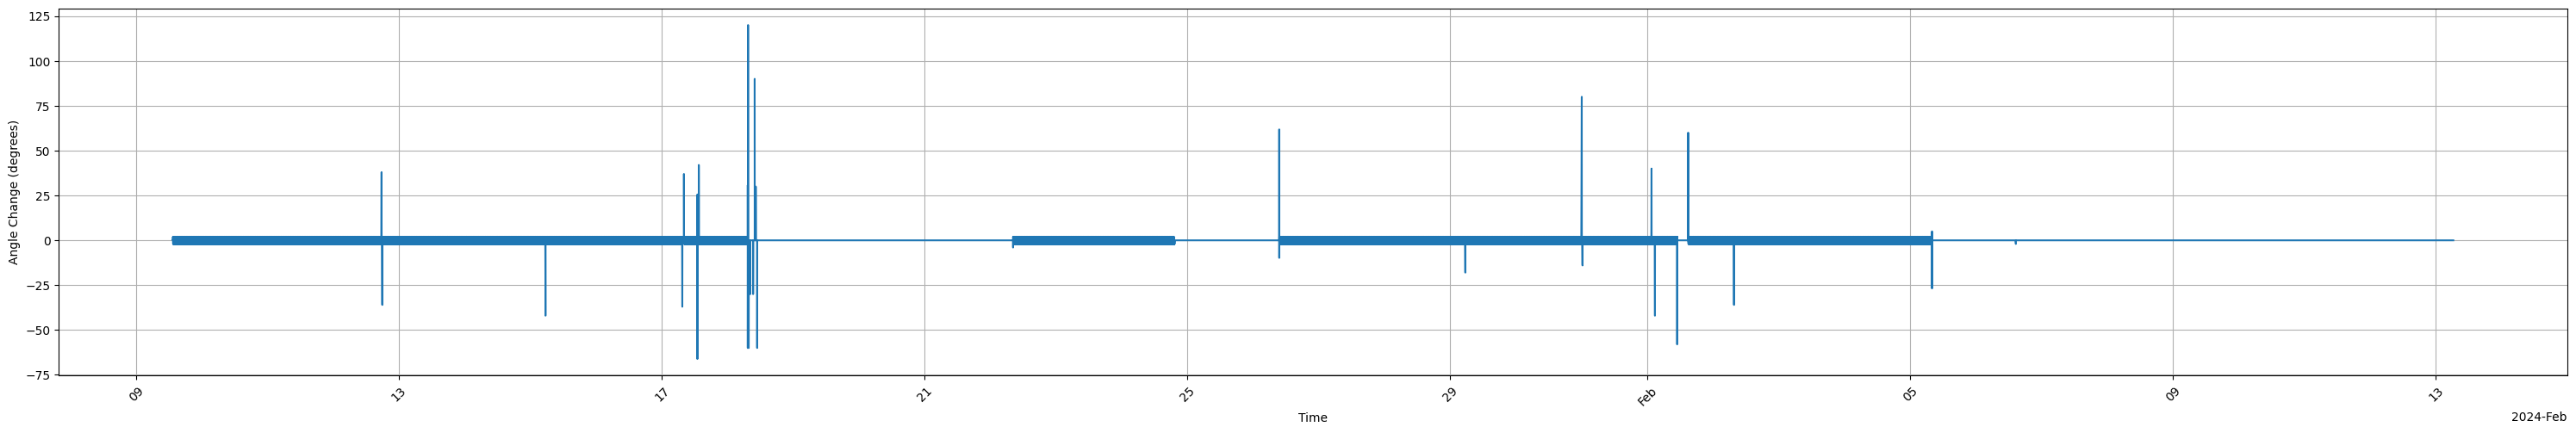

In [240]:
for df in data_frames:
    plt.figure(figsize=(30, 5))
    plt.plot(df["times"], df["setanglet2"].diff())
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
    plt.ylabel('Angle Change (degrees)')
    plt.xlabel('Time')
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

In [236]:
df["AngleChange"] = df["setanglet2"].diff()
df['NonZeroChange'] = (df['AngleChange'] != 0) & (df['AngleChange'].abs() <= 10)
df['SignChange'] = np.nan
df.loc[df['NonZeroChange'], 'SignChange'] = np.sign(df['AngleChange'])
df['SignChange'] = df['SignChange'].fillna(method='ffill')
df['DirectionChange'] = (df['SignChange'].diff() != 0) & df['NonZeroChange'] & (df['northsensoranglet2'].abs() >50)



C:\Users\o.abdulmalik\AppData\Local\Temp\ipykernel_56232\2643443760.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["AngleChange"] = df["setanglet2"].diff()
C:\Users\o.abdulmalik\AppData\Local\Temp\ipykernel_56232\2643443760.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NonZeroChange'] = (df['AngleChange'] != 0) & (df['AngleChange'].abs() <= 10)
C:\Users\o.abdulmalik\AppData\Local\Temp\ipykernel_56232\2643443760.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

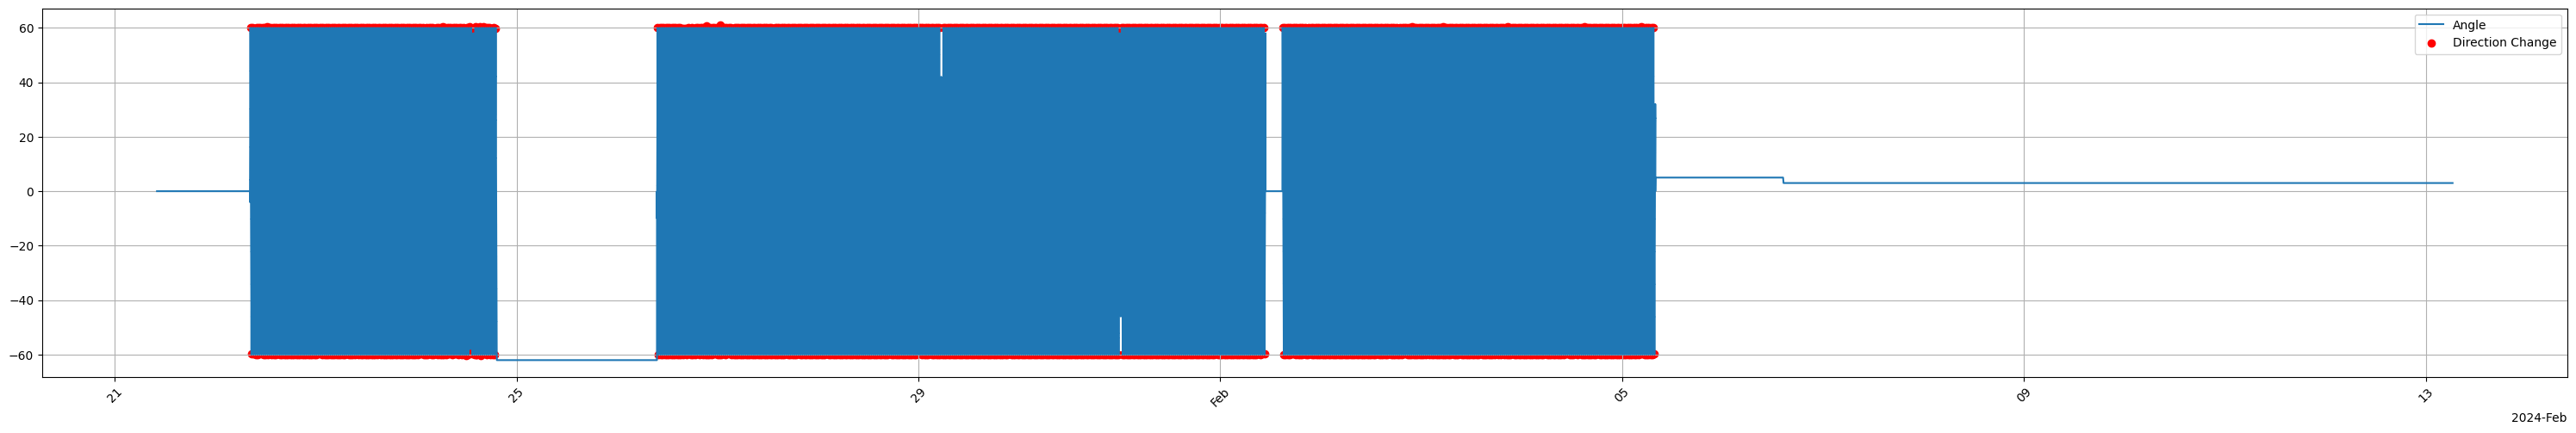

In [237]:
# To visualize these points on a plot
plt.figure(figsize=(30, 5))
plt.plot(df['times'], df['setanglet2'], label='Angle')
plt.scatter(df['times'][df['DirectionChange']], df['northsensoranglet2'][df['DirectionChange']], color='red', label='Direction Change')
plt.title(f'Peaks: {df['DirectionChange'].sum()}')
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.legend()
plt.show()


1211